# Water Quality Parameters - istSOS upload

The current notebook introduces the computation and ingestion of the aggregate descriptive statistics, on a basins level, of the Water Quality Paramenters produced under the framework of SIMILE project into the [istSOS](http://www.istsos.org/) platform. Additional information on the istSOS capabilities and REST API can be found in its [documentation](http://istsos.org/en/latest/doc/) page.

## 0. Setup Working Environment

### Working libraries and Notebook setup

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')


# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

In [2]:
# Data
import numpy as np
import pandas as pd
import pytz
import json
import requests

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show_hist

# Import custom libraries
import wqp_istSOS as istsos
import wqpFunctions as wqp

# Widgets
import ipywidgets as wg

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './out/image_coregistration/',
    'out': './out/istSOS/',
    'vector': './vector',
}

### istSOS client authentication

In SIMILE, two different instances of istSOS have been implemented for the data upload depending on the lakes. One for lake Lugano, and a second for Lake Como and Maggiore. For this reason, it is required specifying the proper hosting endpoint, service and credentials to trigger the different procedures fot data ingestion.

The hosting endpoints for each instance are the following:
- Lake Lugano: `'https://istsos.ddns.net/'`
- Lake Como and Maggiore: `'http://150.145.35.198:2000'`

The user credentials can be found in the following env files for each lake:
- Lake Lugano: `'../env_lugano.json'`
- Lake Como and Maggiore: `'../env_como_maggiore.json'`

The service for each lake is the following:
- Lake Lugano: `'ceresiohourly'`
- Lake Como: `'lariolive'`
- Lake Maggiore: `'maggiorelive'`

**Note:** The list of names for the procedures are provided in `./src/python/wqp_istSOS.py`

In [43]:
c = istsos.istSOSClient(HOST='http://150.145.35.198:2000',
                        HEADERS=istsos.istSOSClient.HEADERS,
                        SERVICE='lariolive',
                        PROCEDURE_LAKE='COMO',
                        ENV_FILE='../env_como_maggiore.json')

The defined user contains the following information to reach istSOS for the data upload

In [44]:
c.__dict__

{'payload': {'grant_type': 'password',
  'client_id': 'istsos-istsos',
  'username': 'satellite',
  'password': 'ag7jF5=='},
 'headers': {'Content-Type': 'application/x-www-form-urlencoded'},
 'tokenUrl': 'http://150.145.35.198:2000/auth/realms/istsos/protocol/openid-connect/token',
 'apiEndpoint': 'http://150.145.35.198:2000/istsos/wa/istsos/services/lariolive',
 'procedures': ['SATELLITE_CHL_TURB_CO_EAST',
  'SATELLITE_CHL_TURB_CO_NORTH',
  'SATELLITE_CHL_TURB_CO_WEST',
  'SATELLITE_CHL_TURB_CO_EAST_1Q',
  'SATELLITE_CHL_TURB_CO_NORTH_1Q',
  'SATELLITE_CHL_TURB_CO_WEST_1Q',
  'SATELLITE_CHL_TURB_CO_EAST_3Q',
  'SATELLITE_CHL_TURB_CO_NORTH_3Q',
  'SATELLITE_CHL_TURB_CO_WEST_3Q',
  'SATELLITE_CHL_TURB_CO_EAST_SD',
  'SATELLITE_CHL_TURB_CO_NORTH_SD',
  'SATELLITE_CHL_TURB_CO_WEST_SD',
  'SATELLITE_TEMP_CO_EAST',
  'SATELLITE_TEMP_CO_NORTH',
  'SATELLITE_TEMP_CO_WEST',
  'SATELLITE_TEMP_CO_EAST_1Q',
  'SATELLITE_TEMP_CO_NORTH_1Q',
  'SATELLITE_TEMP_CO_WEST_1Q',
  'SATELLITE_TEMP_CO_EAST_

In order to trigger the different procedures for data ingestion into the plaftorm it is required to retrive its corresponding **id**.

In [45]:
# Retrieve the id for the procedure using the curent client session in istSOS with the provided credentials.
c.updateBearerToken() # Make sure that the current token for the user is still valid.
assigned_sensor_id = c.getProcedureIDs()

KeyboardInterrupt: 

In [7]:
assigned_sensor_id

{'SATELLITE_CHL_TURB_LUG_NORTH': 'be79cafc2aa311edba3b0242ac130008',
 'SATELLITE_CHL_TURB_LUG_SOUTH': 'a794c25c2aa311ed8c6e0242ac130008',
 'SATELLITE_CHL_TURB_LUG_NORTH_1Q': '',
 'SATELLITE_CHL_TURB_LUG_SOUTH_1Q': '',
 'SATELLITE_CHL_TURB_LUG_NORTH_3Q': '',
 'SATELLITE_CHL_TURB_LUG_SOUTH_3Q': '',
 'SATELLITE_CHL_TURB_LUG_NORTH_SD': '',
 'SATELLITE_CHL_TURB_LUG_SOUTH_SD': '',
 'SATELLITE_TEMP_LUG_NORTH': 'f82537242aa311eda7260242ac130008',
 'SATELLITE_TEMP_LUG_SOUTH': '0d4750d52aa411edbf2c0242ac130008',
 'SATELLITE_TEMP_LUG_NORTH_1Q': '',
 'SATELLITE_TEMP_LUG_SOUTH_1Q': '',
 'SATELLITE_TEMP_LUG_NORTH_3Q': '',
 'SATELLITE_TEMP_LUG_SOUTH_3Q': '',
 'SATELLITE_TEMP_LUG_NORTH_SD': '',
 'SATELLITE_TEMP_LUG_SOUTH_SD': ''}

## 1. Vector Data - Basins

In this section, we import the vector layer for the computation of the aggregate statistics, based in the features of the imported layer. In this case, for the division of the lakes ata a basing level.

In [8]:
from matplotlib_scalebar.scalebar import ScaleBar

In [9]:
# Layer dataset
gdf_basins = gpd.read_file(os.path.join(cwd['vector'],'simile_basins','simile_basins.shp'))

In [10]:
gdf_basins

,fid,Basin,Lake,LakeProc,LakeCode,geometry
0,6.0,EAST,COMO,CO_EAST,CO,"POLYGON ((520518.092 5093093.879, 522566.559 5..."
1,4.0,NORTH,COMO,CO_NORTH,CO,"POLYGON ((520460.123 5093106.857, 518161.390 5..."
2,5.0,WEST,COMO,CO_WEST,CO,"POLYGON ((518161.390 5094524.193, 520460.123 5..."
3,2.0,NORTH,LUGANO,LUG_NORTH,LUG,"POLYGON ((497571.097 5089990.306, 497552.596 5..."
4,3.0,SOUTH,LUGANO,LUG_SOUTH,LUG,"POLYGON ((497295.590 5088812.453, 497285.071 5..."
5,1.0,ALL,MAGGIORE,MA_ALL,MA,"POLYGON ((466844.138 5071980.168, 466841.138 5..."


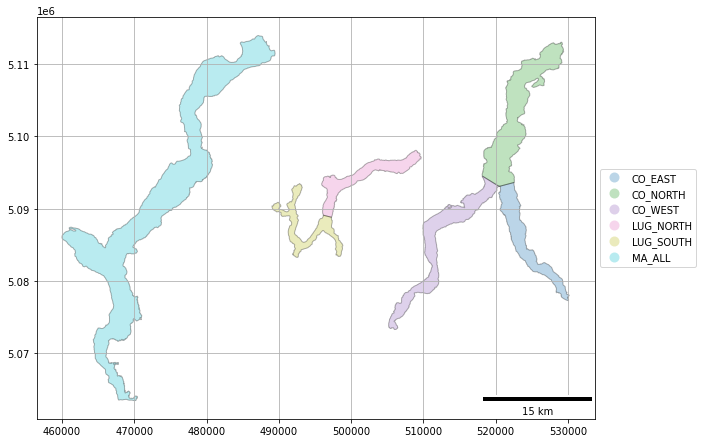

In [11]:
fig ,ax = plt.subplots(1,1,figsize=(10,10))
gdf_basins.plot(ax = ax, edgecolor="black", alpha = 0.3, column = 'LakeProc', legend = True,\
               legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.grid()

scale1 = ScaleBar(
    dx=1,
    location='lower right',  # in relation to the whole plot
    label_loc='left', scale_loc='bottom'  # in relation to the line
)
ax.add_artist(scale1)

## 2. Compute Descriptive Statistics - Basin Level

In the following section, it will be possible to select the procedure used for the data upload. After selecting the procedure of interest, a sample of the data format will be requested, this sample will serve for the update of new statistics upload.

### Procedure Selection - Data Formatting for upload

In [12]:
procedure = wg.Select(
    options = c.procedures,
    value = c.procedures[0],
    description = 'Select the procedure:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

In [13]:
sensor = wg.Select(
    options = ['S3', 'L8'],
    value = 'S3',
    description = 'Select the sensor:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

Select the procedure of interest to extract/ingest data into the selected istSOS instance.

The sensor selection accounts for a further step in obtaining estimates for the Water Quality Parameters of Interest.

In [14]:
wg.HBox([procedure, sensor])

In [32]:
c.updateBearerToken()
data = c.getRequestSample(procedure.value)

GetObservation requested successfully executed


In [33]:
# Sample observation for the selected procedure
data

{'name': 'SATELLITE_CHL_TURB_LUG_SOUTH',
 'samplingTime': {'beginPosition': '2019-01-15T10:12:00+00:00',
  'endPosition': '2022-08-11T10:04:00+00:00',
  'duration': 'P1303DT23H52M'},
 'procedure': 'urn:ogc:def:procedure:x-istsos:1.0:SATELLITE_CHL_TURB_LUG_SOUTH',
 'observedProperty': {'CompositePhenomenon': {'id': 'comp_87',
   'dimension': '5',
   'name': 'timeSeriesOfObservations'},
  'component': ['urn:ogc:def:parameter:x-istsos:1.0:time:iso8601',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:a',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:a:qualityIndex',
   'urn:ogc:def:parameter:x-istsos:1.0:water:TSS',
   'urn:ogc:def:parameter:x-istsos:1.0:water:TSS:qualityIndex']},
 'featureOfInterest': {'name': 'urn:ogc:def:feature:x-istsos:1.0:Point:lugano_basin_south',
  'geom': "<gml:Point srsName='EPSG:4326'><gml:coordinates>8.90780249008498,45.9177648931359,270.5</gml:coordinates></gml:Point>"},
 'result': {'DataArray': {'elementCount': '5',
   'field': [{'name': 'Time',
     'de

### Export Basin Stats to CSV files

For each of the different WQP, multiple products have been extracted. In general, the stats are computed for the WQP maps that passed through the outlier detection/rejection process with the 3$\sigma$ filter.

In [17]:
# Typology of the products
typology_list = [
    'chl',
    'tsm',
    'lswt'
]
# Outlie Rejection methods
or_list = [
    'IQR',
    '2Sigma',
    '3Sigma'
]

# Subset to the buffer size (same used as for the coregistration)
featureGeometry = os.path.join(cwd['vector'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')

In [18]:
typology = wg.Select(
    options = typology_list,
    value = typology_list[0],
    description = 'Select the WQP type:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

orMethod = wg.Select(
    options = or_list,
    value = or_list[0],
    description = 'Select the OR method:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

# Widgets
wg.HBox([typology, orMethod])

In [19]:
in_path = os.path.join(cwd['in'],'wqp','full_coregistered_or',orMethod.value,typology.value)
in_path

'./out/image_coregistration/wqp/full_coregistered_or/IQR/chl'

In [20]:
# in_path = os.path.join(cwd['in'],'wqp',orMethod.value,typology.value)

# In case it is required cropping the maps

# out_path = os.path.join(in_path,'cropped')
# shared_maps = list(set(os.listdir(in_path)).intersection(os.listdir(out_path)))
# missing_maps = list(set(os.listdir(in_path)) ^ set(os.listdir(out_path)))
# print(missing_maps)
# for root, dirs, files in os.walk(in_path):
#     for f in missing_maps:
#         if ((f.endswith('.tif')) & (dirs==['cropped'])):
#             chl_map = os.path.join(in_path,f)
#             print(chl_map)
#             wqp_map = wqp.wqp(chl_map)
#             wqp_map.readWQP()
#             wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
#             d_temp = wqp_map.crops['wqp']['crop']
#             d_temp[d_temp<0] = 0
#             wqp_map.crops['wqp']['crop'] = d_temp
#             wqp_map.saveMaskedImage(os.path.join(out_path,wqp_map.name+'.tif'),'wqp',band=1)
#             wqp_map.image.close()

In [58]:
if typology.value in ['chl','tsm']:
    in_path = os.path.join(cwd['in'],'wqp','full_coregistered_or',orMethod.value,typology.value)
    stats = os.path.join(in_path,f'lakesStats_{typology.value}.csv')
elif typology.value in ['lswt']:
    in_path = os.path.join('./out/outlier_rejection/wqp',orMethod.value,typology.value)
    stats = os.path.join('./out/outlier_rejection/wqp',orMethod.value,typology.value,f'lakesStats_{typology.value}.csv')

In [59]:
# Take into account that some of the files have already been analyzed
data = []
for root, dirs, files in os.walk(in_path):
    if root.split('/')[-1]!='outliers':
        if os.path.exists(stats):
            df = pd.read_csv(stats)
            stats_file_names = set(list(df['name']+'.tif'))
            missing_stats = list(stats_file_names ^ set(os.listdir(in_path)))
        else:
            missing_stats = files
        for file in missing_stats:
            if ((file.endswith('.tif')) & (root.split('\\')[-1]!='outliers')):
                print(root,file)
                f = os.path.join(root,file)

                # Read file
                src = wqp.wqp(f)
                src.readWQP()
                src.name

                # Compute statistics for the basins polygons
                src.computeStatistics(gdf_basins, 'LakeProc',"count min mean max median std  percentile_25 percentile_50 percentile_75", -9999)

                # Format output
                data.append(wqp.wqp.exportWQPFormatStats(src))

df = pd.concat(data)
# Add values to csv file
istsos.appendStatsFile(df, stats) 

./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190101T093449_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190107T101943_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190108T095332_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190109T092721_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190112T094948_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190113T092337_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190115T101215_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190116T094604_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190117T091953_L1.tif
./out/image_coregistration/wqp/full_coregistered_or/3Sigma/tsm S3A_TSM_IT_20190119T100831_L1.tif
./out/image_coregistration/wqp

### Products for submission to istSOS

In [38]:
# Load dataset
df = pd.read_csv(stats,delimiter=",", encoding='utf-8')

In [39]:
df.head()

,Unnamed: 0,name,path,sensor,typology,crs,date,min_CO_EAST,max_CO_EAST,mean_CO_EAST,...,percentile_75_LUG_SOUTH,min_MA_ALL,max_MA_ALL,mean_MA_ALL,count_MA_ALL,std_MA_ALL,median_MA_ALL,percentile_25_MA_ALL,percentile_50_MA_ALL,percentile_75_MA_ALL
0,0,S3A_CHL_IT_20190101T093449_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-01 09:34:49,-9999.000000,-9999.0000,-9999.000000,...,0.730092,-9999.0,17.324663,-7995.735156,5,4006.529865,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1,0,S3A_CHL_IT_20190107T101943_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-07 10:19:43,-9999.000000,-9999.0000,-9999.000000,...,NaN,-9999.0,9.161366,-17.490569,1807,470.141819,4.763474,4.410875,4.763474,4.976875
2,0,S3A_CHL_IT_20190108T095332_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-08 09:53:32,-9999.000000,-9999.0000,-9999.000000,...,-9999.000000,-9999.0,-9999.000000,-9999.000000,9,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
3,0,S3A_CHL_IT_20190109T092721_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-09 09:27:21,0.195821,3.8049,2.096348,...,19.625387,-9999.0,-9999.000000,-9999.000000,4,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
4,0,S3A_CHL_IT_20190112T094948_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-12 09:49:48,-9999.000000,-9999.0000,-9999.000000,...,-9999.000000,-9999.0,-9999.000000,-9999.000000,9,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000


In [19]:
file_name = os.path.join('./out/istSOS','lakeStats_CHL_TSM.csv')
df = pd.read_csv(file_name,delimiter=",")

In [20]:
df.keys()

Index(['Unnamed: 0', 'name', 'path', 'sensor', 'typology', 'crs', 'date',
       'count_CO_EAST', 'min_CO_EAST', 'mean_CO_EAST', 'max_CO_EAST',
       'median_CO_EAST', 'std_CO_EAST', 'percentile_25_CO_EAST',
       'percentile_50_CO_EAST', 'percentile_75_CO_EAST', 'count_CO_NORTH',
       'min_CO_NORTH', 'mean_CO_NORTH', 'max_CO_NORTH', 'median_CO_NORTH',
       'std_CO_NORTH', 'percentile_25_CO_NORTH', 'percentile_50_CO_NORTH',
       'percentile_75_CO_NORTH', 'count_CO_WEST', 'min_CO_WEST',
       'mean_CO_WEST', 'max_CO_WEST', 'median_CO_WEST', 'std_CO_WEST',
       'percentile_25_CO_WEST', 'percentile_50_CO_WEST',
       'percentile_75_CO_WEST', 'count_LUG_NORTH', 'min_LUG_NORTH',
       'mean_LUG_NORTH', 'max_LUG_NORTH', 'median_LUG_NORTH', 'std_LUG_NORTH',
       'percentile_25_LUG_NORTH', 'percentile_50_LUG_NORTH',
       'percentile_75_LUG_NORTH', 'min_LUG_SOUTH', 'max_LUG_SOUTH',
       'mean_LUG_SOUTH', 'count_LUG_SOUTH', 'std_LUG_SOUTH',
       'median_LUG_SOUTH', 'percenti

In [21]:
df.shape

(2878, 61)

In [22]:
filters = ['std_CO_EAST','std_CO_NORTH','std_CO_NORTH','std_MA_ALL','std_LUG_NORTH','std_LUG_SOUTH']

In [23]:
for f in filters:
    df = df[df[f]>0]
    df.dropna(inplace=True)

In [24]:
df.shape

(725, 61)

In [25]:
df.to_csv(os.path.join('./out/istSOS',f'lakeStats_CHL_TSM_submit.csv'))

PermissionError: [Errno 13] Permission denied: './out/istSOS/lakeStats_CHL_TSM_submit.csv'

### istSOS JSON format

In case of S3, it is needed to import both reference data files for the computed statistics

In [34]:
# Load the statistics files
# file_name = os.path.join(in_path,f'lakesStats_{typology.value}_submit.csv')
file_name = os.path.join('./out/istSOS',f'lakeStats_CHL_TSM_submit.csv')
df = pd.read_csv(file_name,delimiter=",")
df.date = pd.to_datetime(df.date)

In [35]:
df = df.dropna()
df = df.sort_values(by=['date'])
df = df.round(2)
df.shape

(725, 62)

In [36]:
df.head()

,Unnamed: 0,Unnamed: 0.1,name,path,sensor,typology,crs,date,count_CO_EAST,min_CO_EAST,...,percentile_75_LUG_SOUTH,min_MA_ALL,max_MA_ALL,mean_MA_ALL,count_MA_ALL,std_MA_ALL,median_MA_ALL,percentile_25_MA_ALL,percentile_50_MA_ALL,percentile_75_MA_ALL
0,6,0,S3A_CHL_IT_20190115T101215_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-15 10:12:15,196,1.72,...,7.02,0.11,9.83,4.20,1718,0.86,4.16,3.69,4.16,4.64
363,1445,0,S3A_TSM_IT_20190115T101215_L1,./out/image_coregistration/wqp/full_coregister...,S3A,TSM,IT,2019-01-15 10:12:15,201,0.02,...,0.84,0.01,2.01,0.59,1718,0.26,0.57,0.39,0.57,0.75
1,11,0,S3A_CHL_IT_20190121T091609_L1,./out/image_coregistration/wqp/full_coregister...,S3A,CHL,IT,2019-01-21 09:16:09,70,0.85,...,0.40,0.07,5.77,3.44,970,1.11,3.57,2.83,3.57,4.25
364,1450,0,S3A_TSM_IT_20190121T091609_L1,./out/image_coregistration/wqp/full_coregister...,S3A,TSM,IT,2019-01-21 09:16:09,70,0.06,...,0.01,0.00,0.82,0.25,970,0.18,0.24,0.08,0.24,0.38
582,2295,0,S3B_TSM_IT_20190122T095127_L1,./out/image_coregistration/wqp/full_coregister...,S3B,TSM,IT,2019-01-22 09:51:27,171,0.02,...,0.62,0.02,2.50,0.55,1639,0.18,0.53,0.43,0.53,0.65


In [37]:
max(df.date)

Timestamp('2022-10-07 09:48:10')

In [38]:
istsos.istSOSClient.WQP_PROCEDURES

['CHL', 'CHL_1Q', 'TURB', 'TEMP']

In [39]:
procedure.value

'SATELLITE_CHL_TURB_LUG_SOUTH'

In [40]:
#TODO: update the updateDataRequest and resultsWQPvalues functions for the new procedures naming convention
a = istsos.updateDataRequest(df=df,
                    dataSample=data, 
                    WQP_DEFINITIONS=istsos.istSOSClient.WQP_DEFINITIONS,
                    WQP_PROCEDURES=istsos.istSOSClient.WQP_PROCEDURES,
                    PROCEDURE=procedure.value)

['TURB', 'CHL']
2019-01-15T10:12:15Z
2022-10-07T09:48:10Z
Missing value: 2021-05-25T09:50:03.000000000 : TSM : LUG_SOUTH


In [41]:
a

{'name': 'SATELLITE_CHL_TURB_LUG_SOUTH',
 'samplingTime': {'beginPosition': '2019-01-15T10:12:15Z',
  'endPosition': '2022-10-07T09:48:10Z'},
 'procedure': 'urn:ogc:def:procedure:x-istsos:1.0:SATELLITE_CHL_TURB_LUG_SOUTH',
 'observedProperty': {'CompositePhenomenon': {'id': 'comp_87',
   'dimension': '3',
   'name': 'timeSeriesOfObservations'},
  'component': ['urn:ogc:def:parameter:x-istsos:1.0:time:iso8601',
   'urn:ogc:def:parameter:x-istsos:1.0:water:TSS',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:a']},
 'featureOfInterest': {'name': 'urn:ogc:def:feature:x-istsos:1.0:Point:lugano_basin_south',
  'geom': "<gml:Point srsName='EPSG:4326'><gml:coordinates>8.90780249008498,45.9177648931359,270.5</gml:coordinates></gml:Point>"},
 'result': {'DataArray': {'elementCount': '3',
   'field': [{'name': 'Time',
     'definition': 'urn:ogc:def:parameter:x-istsos:1.0:time:iso8601'},
    {'name': 'water-TSS',
     'definition': 'urn:ogc:def:parameter:x-istsos:1.0:water:TSS',
     'uom': 'g/

In [ ]:
# # Get Observation
# SERVICE_NAME = 'demo'
# OFFERING_NAME = 'temporary'
# PROCEDURE_NAME = 'SATELLITE_CHL_TURB_CO_EAST'
# DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl'
# BEGIN_TIME = "2020-01-01T00:01:00+01"
# END_TIME = "2020-01-17T00:01:00+01"

# url_base = "https://istsos.ddns.net/istsos/"
# url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/{DEFINITION_URNs}/eventtime/{BEGIN_TIME}/{END_TIME}"
# resp = requests.get(url_test, headers=c.requestHeaders)
# resp.text


In [ ]:
# WQP_PROCEDURES = ['CHL','TURB','WT']
# a = procedure.value.split('_')
# wqps = list(set(a).intersection(WQP_PROCEDURES))


In [ ]:
# # INSERT OBSERVATION PARAMETERS

# ########## PARAMETERS TO BE EDITED ####################
# LAKE = 'CO' # {CO: COMO, LU: LUGANO, MA: MAGGIORE}
# WQP_INPUT = ['LSWT'] #['LSWT','CHL','TSM']
# #######################################################

# DATE_START = pytz.utc.localize(df.date.min()).isoformat().replace('+00:00','Z')
# DATE_END = pytz.utc.localize(df.date.max()).isoformat().replace('+00:00','Z')


# if LAKE == 'CO':
#     BASINS_LIST = ['CO_NORTH','CO_EAST','CO_WEST']
# elif LAKE == 'LU':
#     BASINS_LIST = ['LU_EAST','LU_WEST']
# elif LAKE == 'MA':
#     BASINS_LIST = ['MA_ALL']
    
# # Observed properties
# OP_COMPOSITE_PHENOMENON_ID = 'comp_1' #random name?
# OP_COMPOSITE_PHENOMENON_DIMENSION = '{}'.format(len(WQP_INPUT)+1) #int number of input observed variables (not observations)
# OP_COMPONENT = ["urn:ogc:def:parameter:x-istsos:1.0:time:iso8601"]
# for wqp in WQP_INPUT: #Observed parameters names: {'lswt':'water-temperature';'chl'}
#     if 'LSWT' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water-temperature")
#     elif 'CHL' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water:Chl")
#     elif 'TSM' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water:Turb")

# #Results
# RES_DA_ELEMENT_COUNT = OP_COMPOSITE_PHENOMENON_DIMENSION # Does this parameter have the same magnitude as the composite dimension?
# RES_DA_FIELDS = [
#     {
#         "name": "Time",
#         "definition": "urn:ogc:def:parameter:x-istsos:1.0:time:iso8601"
#     },
# ]
# for wqp in WQP_INPUT: #Observed parameters names: {'lswt':'water-temperature';'chl'}
#     if 'LSWT' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-temperature",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water-temperature",
#                 "uom":"\u00b0C"
#             }
#         )
#     elif 'CHL' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-Chl",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water:Chl",
#                 "uom":"mg/m^3"
#             }
#         )
#     elif 'TSM' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-Turb",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water:Turb",
#                 "uom":"g/m^3"
#             }
#         )

# # Create insertObsevartion model for istSOS depending on the procedure.
# for PROCEDURE in PROCEDURES_LIST:
#     obs = {
#         "AssignedSensorId":f"{ASSIGNED_SENSOR_ID[PROCEDURE]}",
#         "ForceInsert":"false",
#         "Observation":{
#             "name":f"{PROCEDURE}",
#             "samplingTime":{
#             "beginPosition":f"{DATE_START}",
#             "endPosition":f"{DATE_END}"
#             },
#             "procedure":f"urn:ogc:def:procedure:x-istsos:1.0:{PROCEDURE}",
#             "observedProperty": {
#                 "CompositePhenomenon":{
#                     "id":f"{OP_COMPOSITE_PHENOMENON_ID}", 
#                     "dimension":f"{OP_COMPOSITE_PHENOMENON_DIMENSION}", 
#                     "name":"timeSeriesOfObservations"
#                 },
#                 "component": OP_COMPONENT
#             },
#             "featureOfInterest":{ # Is it necessary to assign the value to a geometry? 
#                 "name":f"urn:ogc:def:feature:x-istsos:1.0:Point:{PROCEDURE}",
#                 "geom":f"{istsos.getGMLfeature(os.path.join(cwd['out'],'procedures_istSOS'), PROCEDURE+"_point")}" 
#             },
#             "result": {
#                 "DataArray": {
#                     "elementCount":f"{RES_DA_ELEMENT_COUNT}",
#                     "field": RES_DA_FIELDS,
#                     "values": istsos.resultsWQPvalues(df,'_'.join(PROCEDURE.split('_')[-2:])),#BASIN
#                 }
#             }
#         }
#     }
#     print('_'.join(PROCEDURE.split('_')[-2:]))
#     with open(os.path.join(cwd['out'],f"{PROCEDURE}.json"), "w", encoding="UTF-8") as outfile:
#         json.dump(obs, outfile, ensure_ascii=False, indent=4)

### Data Ingestion to istSOS

In [28]:
obs = {
    "AssignedSensorId":f"{assigned_sensor_id[procedure.value]}",
    "ForceInsert":"true",
    "Observation": a
}

In [29]:
obs

{'AssignedSensorId': 'be79cafc2aa311edba3b0242ac130008',
 'ForceInsert': 'true',
 'Observation': {'name': 'SATELLITE_CHL_TURB_LUG_NORTH',
  'samplingTime': {'beginPosition': '2019-01-15T10:12:15Z',
   'endPosition': '2022-10-07T09:48:10Z'},
  'procedure': 'urn:ogc:def:procedure:x-istsos:1.0:SATELLITE_CHL_TURB_LUG_NORTH',
  'observedProperty': {'CompositePhenomenon': {'id': 'comp_88',
    'dimension': '3',
    'name': 'timeSeriesOfObservations'},
   'component': ['urn:ogc:def:parameter:x-istsos:1.0:time:iso8601',
    'urn:ogc:def:parameter:x-istsos:1.0:water:TSS',
    'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:a']},
  'featureOfInterest': {'name': 'urn:ogc:def:feature:x-istsos:1.0:Point:lugano_basin_north',
   'geom': "<gml:Point srsName='EPSG:4326'><gml:coordinates>9.01129783380814,46.0036237146487,270.5</gml:coordinates></gml:Point>"},
  'result': {'DataArray': {'elementCount': '3',
    'field': [{'name': 'Time',
      'definition': 'urn:ogc:def:parameter:x-istsos:1.0:time:iso8601'

In [30]:
print(os.path.join(cwd['out'],f"{procedure.value}.json"))

./out/istSOS/SATELLITE_CHL_TURB_LUG_NORTH.json


In [42]:
with open(os.path.join(cwd['out'],f"{procedure.value}_new.json"), "w", encoding="UTF-8") as outfile:
    json.dump(obs, outfile, ensure_ascii=False, indent=4)

In [ ]:
c.updateBearerToken()
c.requestHeaders

In [ ]:
json.dumps(obs)

In [ ]:
file_name_json = f'{procedure.value}.json'
filepath = os.path.join(cwd['out'], sensor.value,file_name_json)
print(filepath)
f = open(filepath)

data = json.load(f)
d=json.dumps(data)
d

In [ ]:
c.updateBearerToken()

In [ ]:
#Insert Observation into istSOS test
url = 'https://istsos.ddns.net/istsos/wa/istsos/services/ceresiohourly/operations/insertobservation'
response = requests.post(url,data=json.dumps(obs),headers=c.requestHeaders)
# response = requests.post(url,data=d,headers=c.requestHeaders)
print(response.status_code)
print(response.text)

In [ ]:
data

In [ ]:
url_base = "https://istsos.ddns.net/istsos/wa/istsos/services/ceresiohourly"
# # Sample request. Retrieve al the available procedures in the platform
# url_test = f"{url_base}/procedures/operations/getlist"
url_test =f"{url_base}/procedures/{procedure.value}"
# url_test =f"{url_base}/procedures/SATELLITE_CHL_TURB_CO_NORTH"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
data

In [ ]:
file_name_json = 'SATELLITE_CHL_TURB_CO_NORTH_2.json'
filepath = os.path.join(cwd['out'], sensor.value,file_name_json)
f = open(filepath)
data = json.load(f)
d=json.dumps(data)
d

### Testing istSOS API  calls

In [ ]:
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/{istsos.istSOSClient.SERVICE}/procedures/operations/getlist"
resp = requests.get(url_test,headers=c.requestHeaders)
resp.text

In [ ]:
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/demo/procedures/operations/geojson"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
# Get Offerings
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/demo/offerings/operations/getlist"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [9]:
# Get Observation
SERVICE_NAME = 'ceresiohourly'
OFFERING_NAME = 'temporary'
PROCEDURE_NAME = procedure.value
# DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:a&urn:ogc:def:parameter:x-istsos:1.0:water:TSS'
DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:temperature'
BEGIN_TIME = "2019-01-04T09:54:16Z"
END_TIME = "2022-08-26T09:58:18Z"

url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/{DEFINITION_URNs}/eventtime/{BEGIN_TIME}/{END_TIME}"
resp = requests.get(url_test, headers=c.requestHeaders)
resp.text


NameError: name 'procedure' is not defined

In [ ]:
# Get Observation
SERVICE_NAME = 'demo'
OFFERING_NAME = 'temporary'
PROCEDURE_NAME = 'SATELLITE_CHL_TURB_CO_WEST'
DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl'
BEGIN_TIME = "2019-01-01T00:01:00+01"
END_TIME = "2022-01-17T00:01:00+01"

url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/:/eventtime/last"
resp = requests.get(url_test, headers=c.requestHeaders)
resp.json()


In [ ]:
data = resp.json()

In [ ]:
data['data']